In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aquarel as aq
from ineqpy.inequality import gini
import scipy.stats as st
import pyalex as alex
alex.config.email = "noah0roussel01980@gmail.com"

In [2]:
works_bjp = pl.read_csv("../data/works/works_bjp.csv")
works_bjp = works_bjp.filter(pl.col("year") != 2025)

In [3]:
works = pl.read_csv("../data/works/works_q1.csv")
works = works.filter(pl.col("year") != 2025)

In [ ]:
year_begin = 1920
year_end = 2024
works_bjp = works_bjp.with_columns(
    age=2025 - pl.col("year")
)

bjp_cbc_per_year = (
    works_bjp
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) 

works_bjp = works_bjp.join(
    bjp_cbc_per_year,
    on="year",
    how="left"
) 

works_bjp = (
    works_bjp
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
bjp_cols_authors = [col for col in works_bjp.columns if col.startswith("author_")]

works_bjp = works_bjp.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in bjp_cols_authors]
    )

)

works_bjp = works_bjp.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works_bjp = works_bjp.with_columns(
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works_bjp = works_bjp.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works_bjp = works_bjp.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])


bjp_group_references_mean = (
    works_bjp.lazy()  
    .filter(~pl.col("review") & ~pl.col("meta_analysis"))
    .group_by("referenced_works_count")
    .agg([
        pl.col("mncs").mean().alias("mncs"),
        pl.len().alias("count")
    ])
    .sort("referenced_works_count")
    .collect()  
)

works_bjp

title,year,cited_by_count,countries_distinct_count,institutions_distinct_count,citation_normalized_percentile,primary_topic,keywords,concepts,referenced_works_count,referenced_works,abstract,abstract_inverted_index,journal,author_1,author_2,author_3,author_4,author_5,institution_1,institution_2,institution_3,institution_4,institution_5,country_1,country_2,country_3,country_4,country_5,cited_by_count_2025,cited_by_count_2024,cited_by_count_2023,cited_by_count_2022,cited_by_count_2021,cited_by_count_2020,cited_by_count_2019,cited_by_count_2018,…,country_108,country_109,country_110,country_111,country_112,country_113,country_114,country_115,country_116,country_117,country_118,country_119,country_120,institution_108,institution_109,institution_110,institution_111,institution_112,institution_113,institution_114,institution_115,institution_116,institution_117,institution_118,institution_119,institution_120,institution_121,institution_122,institution_123,institution_124,institution_125,institution_126,age,mncs,authors_count,review,meta_analysis
str,i64,i64,i64,i64,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,f64,i8,bool,bool
"""animal research: reporting <i>…",2010,3465,1,4,"""{'value': 0.999709, 'is_in_top…","""('Animal testing and alternati…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",6,"""['https://openalex.org/W167468…","""the nc3rs gratefully acknowled…","""{'The': [0, 222], 'NC3Rs': [1,…","""British Journal of Pharmacolog…","""https://openalex.org/A50535847…","""https://openalex.org/A50876564…","""https://openalex.org/A50047534…","""https://openalex.org/A50192845…","""https://openalex.org/A50429626…","""['National Centre for the Repl…","""['University of Bristol', 'htt…","""['University of Bristol', 'htt…","""['Imperial College London', 'h…","""['University of Oxford', 'http…","""GB""","""GB""","""GB""","""GB""","""GB""",104.0,169.0,209.0,239.0,287.0,378.0,396.0,279.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,15,49.882425,5,false,false
"""principles of early drug disco…",2010,2474,1,2,"""{'value': 0.763975, 'is_in_top…","""('Computational Drug Discovery…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",25,"""['https://openalex.org/W150104…","""developing a new drug from ori…","""{'Developing': [0], 'a': [1, 1…","""British Journal of Pharmacolog…","""https://openalex.org/A51099337…","""https://openalex.org/A51141727…","""https://openalex.org/A50660771…","""https://openalex.org/A51099819…",null,"""['GlaxoSmithKline (United King…","""[""King's College London"", 'htt…","""[""King's College London"", 'htt…",null,null,"""GB""","""GB""","""GB""","""GB""",null,197.0,363.0,363.0,308.0,292.0,234.0,150.0,160.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,15,35.615907,4,true,false
"""measuring reactive species and…",2004,2200,1,1,"""{'value': 0.990741, 'is_in_top…","""('Antioxidant Activity and Oxi…","""[]""","""[{'id': 'https://openalex.org/…",386,"""['https://openalex.org/W116935…","""free radicals and other reacti…","""{'Free': [0], 'radicals': [1],…","""British Journal of Pharmacolog…","""https://openalex.org/A50537269…","""https://openalex.org/A50691363…",null,null,null,"""['National University of Singa…","""['National University of Singa…",null,null,null,"""SG""","""SG""",null,null,null,31.0,76.0,81.0,91.0,101.0,127.0,107.0,107.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,21,36.17912,2,true,false
"""guide to receptors a

In [5]:
year_begin = 1920
year_end = 2024
works = works.with_columns(
    age=2025 - pl.col("year")
)

cbc_per_year = (
    works
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) 

works = works.join(
    cbc_per_year,
    on="year",
    how="left"
) 

works = (
    works
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
cols_authors = [col for col in works.columns if col.startswith("author_")]

works = works.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in cols_authors]
    )

)

works = works.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works = works.with_columns(
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works = works.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works = works.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])


group_references_mean = (
    works.lazy()  
    .filter(~pl.col("review") & ~pl.col("meta_analysis"))
    .group_by("referenced_works_count")
    .agg([
        pl.col("mncs").mean().alias("mncs"),
        pl.len().alias("count")
    ])
    .sort("referenced_works_count")
    .collect()  
)

works


title,year,cited_by_count,countries_distinct_count,institutions_distinct_count,citation_normalized_percentile,primary_topic,keywords,concepts,referenced_works_count,referenced_works,abstract,abstract_inverted_index,journal,author_1,author_2,author_3,institution_1,institution_2,institution_3,country_1,country_2,country_3,cited_by_count_2025,cited_by_count_2024,cited_by_count_2023,cited_by_count_2022,cited_by_count_2021,cited_by_count_2020,cited_by_count_2019,cited_by_count_2018,cited_by_count_2017,cited_by_count_2016,cited_by_count_2015,cited_by_count_2014,cited_by_count_2013,cited_by_count_2012,…,country_239,country_240,country_241,country_242,country_243,country_244,country_245,country_246,country_247,country_248,country_249,country_250,country_251,country_252,country_253,country_254,country_255,country_256,country_257,country_258,country_259,country_260,country_261,country_262,country_263,country_264,country_265,country_266,country_267,country_268,country_269,country_270,age,mncs,authors_count,review,meta_analysis
str,i64,i64,i64,i64,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,f64,i8,bool,bool
"""ros stress in cancer cells and…",2004,1881,1,1,"""{'value': 0.816836, 'is_in_top…","""Redox biology and oxidative st…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",158,"""['https://openalex.org/W116540…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50102407…","""https://openalex.org/A50076048…","""https://openalex.org/A51006444…","""['The University of Texas MD A…","""['The University of Texas MD A…","""['The University of Texas MD A…","""US""","""US""","""US""",40.0,71.0,85.0,108.0,133.0,133.0,97.0,91.0,127.0,111.0,119.0,130.0,108.0,117.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,21,35.103559,3,false,false
"""aminoglycoside modifying enzym…",2010,1294,1,1,"""{'value': 0.995475, 'is_in_top…","""Bacteriophages and microbial i…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",336,"""['https://openalex.org/W141030…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50909767…","""https://openalex.org/A50055229…",null,"""['California State University,…","""['California State University,…",null,"""US""","""US""",null,74.0,108.0,123.0,144.0,136.0,162.0,108.0,92.0,72.0,70.0,57.0,52.0,45.0,26.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,15,24.857588,2,false,false
"""overcoming the blood–brain tum…",2015,898,2,6,"""{'value': 0.998282, 'is_in_top…","""Glioma Diagnosis and Treatment""","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",159,"""['https://openalex.org/W148541…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50341518…","""https://openalex.org/A50913295…","""https://openalex.org/A50395930…","""['The Netherlands Cancer Insti…","""['Amsterdam UMC Location Vrije…","""['The Netherlands Cancer Insti…","""NL""","""NL""","""NL""",80.0,87.0,97.0,110.0,116.0,119.0,91.0,80.0,59.0,43.0,15.0,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,10,23.127161,6,false,false
"""targeting the pi3k/akt/mtor pa…",2008,786,1,2,"""{'value': 0.999673, 'is_in_top…","""PI3K/AKT/mTOR signaling in can…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",236,"""['https://openalex.org/W150966…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50898992…","""https://openalex.org/A50296122…","""https://openalex.org/A51080787…",

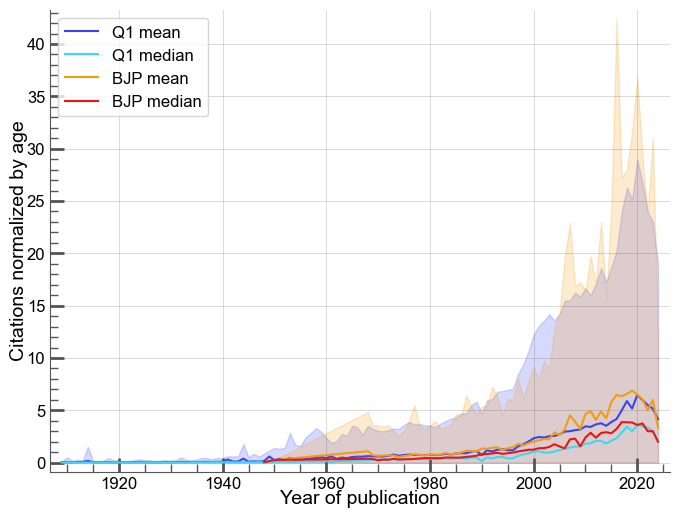

<Figure size 640x480 with 0 Axes>

In [6]:
works = works.with_columns(
    (pl.col("cited_by_count") / pl.col("age")).alias("cited_per_year")
)

works_bjp = works_bjp.with_columns(
    (pl.col("cited_by_count") / pl.col("age")).alias("cited_per_year")
)

agg_exprs_age = [
    pl.mean("cited_per_year").alias("mean"),
    pl.median("cited_per_year").alias("median"),
    pl.col("cited_per_year").quantile(0.025).alias("p2_5"),
    pl.col("cited_per_year").quantile(0.975).alias("p97_5"),
]

group_q1_age = (
    works.group_by("year", maintain_order=True)
    .agg(agg_exprs_age)
    .sort("year")
)

group_bjp_age = (
    works_bjp.group_by("year", maintain_order=True)
    .agg(agg_exprs_age)
    .sort("year")
)

years_q1 = group_q1_age["year"].to_numpy()
mean_q1 = group_q1_age["mean"].to_numpy()
median_q1 = group_q1_age["median"].to_numpy()
low_q1 = group_q1_age["p2_5"].to_numpy()
high_q1 = group_q1_age["p97_5"].to_numpy()

years_bjp = group_bjp_age["year"].to_numpy()
mean_bjp = group_bjp_age["mean"].to_numpy()
median_bjp = group_bjp_age["median"].to_numpy()
low_bjp = group_bjp_age["p2_5"].to_numpy()
high_bjp = group_bjp_age["p97_5"].to_numpy()


with aq.load_theme("scientific"):
    plt.figure(figsize=(8,6))


    plt.plot(years_q1, mean_q1, color="#3944f3", label="Q1 mean")
    plt.plot(years_q1, median_q1, color="#39daf3", label="Q1 median")
    plt.fill_between(years_q1, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(years_bjp, mean_bjp, color="#f39c12", label="BJP mean")
    plt.plot(years_bjp, median_bjp, color="#f31212", label="BJP median")
    plt.fill_between(years_bjp, low_bjp, high_bjp, color="#f39c12", alpha=0.2)

    plt.xlabel("Year of publication", fontsize=14)
    plt.ylabel("Citations normalized by age", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()


In [7]:
import ast
import polars as pl

# Q1
works = works.with_columns([
    pl.Series([ast.literal_eval(x)["value"] if x else None for x in works["citation_normalized_percentile"]]).alias("citation_percentile_value"),
    pl.Series([ast.literal_eval(x)["is_in_top_1_percent"] if x else None for x in works["citation_normalized_percentile"]]).alias("is_top_1_percent"),
    pl.Series([ast.literal_eval(x)["is_in_top_10_percent"] if x else None for x in works["citation_normalized_percentile"]]).alias("is_top_10_percent")
])

# BJP
works_bjp = works_bjp.with_columns([
    pl.Series([ast.literal_eval(x)["value"] if x else None for x in works_bjp["citation_normalized_percentile"]]).alias("citation_percentile_value"),
    pl.Series([ast.literal_eval(x)["is_in_top_1_percent"] if x else None for x in works_bjp["citation_normalized_percentile"]]).alias("is_top_1_percent"),
    pl.Series([ast.literal_eval(x)["is_in_top_10_percent"] if x else None for x in works_bjp["citation_normalized_percentile"]]).alias("is_top_10_percent")
])



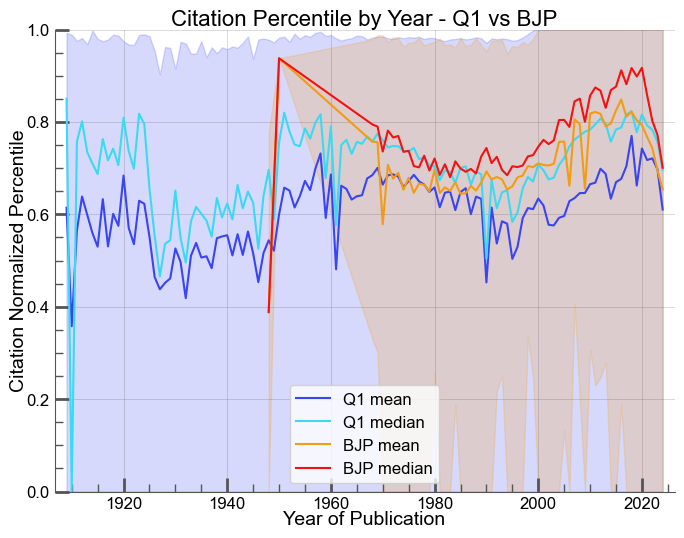

In [8]:
agg_percentile = [
    pl.mean("citation_percentile_value").alias("mean"),
    pl.median("citation_percentile_value").alias("median"),
    pl.col("citation_percentile_value").quantile(0.025).alias("p2_5"),
    pl.col("citation_percentile_value").quantile(0.975).alias("p97_5"),
]

group_q1_perc = works.group_by("year", maintain_order=True).agg(agg_percentile).sort("year")
group_bjp_perc = works_bjp.group_by("year", maintain_order=True).agg(agg_percentile).sort("year")


years_q1 = group_q1_perc["year"].to_numpy()
mean_q1 = group_q1_perc["mean"].to_numpy()
median_q1 = group_q1_perc["median"].to_numpy()
low_q1 = group_q1_perc["p2_5"].to_numpy()
high_q1 = group_q1_perc["p97_5"].to_numpy()

years_bjp = group_bjp_perc["year"].to_numpy()
mean_bjp = group_bjp_perc["mean"].to_numpy()
median_bjp = group_bjp_perc["median"].to_numpy()
low_bjp = group_bjp_perc["p2_5"].to_numpy()
high_bjp = group_bjp_perc["p97_5"].to_numpy()

with aq.load_theme("scientific"):
    plt.figure(figsize=(8,6))

    # Q1
    plt.plot(years_q1, mean_q1, color="#3944f3", label="Q1 mean")
    plt.plot(years_q1, median_q1, color="#39daf3", label="Q1 median")
    plt.fill_between(years_q1, low_q1, high_q1, color="#3944f3", alpha=0.2)

    # BJP
    plt.plot(years_bjp, mean_bjp, color="#f39c12", label="BJP mean")
    plt.plot(years_bjp, median_bjp, color="#f31212", label="BJP median")
    plt.fill_between(years_bjp, low_bjp, high_bjp, color="#f39c12", alpha=0.2)

    plt.xlabel("Year of Publication", fontsize=14)
    plt.ylabel("Citation Normalized Percentile", fontsize=14)
    plt.title("Citation Percentile by Year - Q1 vs BJP", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.ylim(0, 1)  # si ton value est entre 0 et 1
    plt.show()

<Figure size 640x480 with 0 Axes>

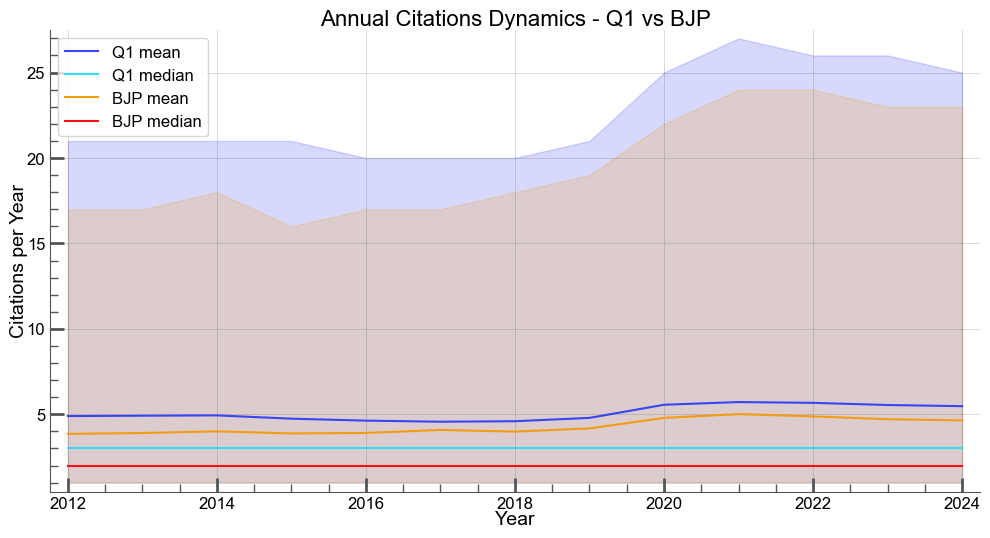

In [9]:
years = list(range(2012, 2025))
cols_cited = [f"cited_by_count_{y}" for y in years]

def yearly_citation_stats(df, cols):
    agg_exprs = []
    for col in cols:
        agg_exprs.append(pl.mean(col).alias(f"{col}_mean"))
        agg_exprs.append(pl.median(col).alias(f"{col}_median"))
        agg_exprs.append(pl.col(col).quantile(0.025).alias(f"{col}_p2_5"))
        agg_exprs.append(pl.col(col).quantile(0.975).alias(f"{col}_p97_5"))
    return df.select(agg_exprs)

stats_q1 = yearly_citation_stats(works, cols_cited)
stats_bjp = yearly_citation_stats(works_bjp, cols_cited)

mean_q1 = [stats_q1[f"{c}_mean"][0] for c in cols_cited]
median_q1 = [stats_q1[f"{c}_median"][0] for c in cols_cited]
low_q1 = [stats_q1[f"{c}_p2_5"][0] for c in cols_cited]
high_q1 = [stats_q1[f"{c}_p97_5"][0] for c in cols_cited]

mean_bjp = [stats_bjp[f"{c}_mean"][0] for c in cols_cited]
median_bjp = [stats_bjp[f"{c}_median"][0] for c in cols_cited]
low_bjp = [stats_bjp[f"{c}_p2_5"][0] for c in cols_cited]
high_bjp = [stats_bjp[f"{c}_p97_5"][0] for c in cols_cited]

with aq.load_theme("scientific"):
    plt.figure(figsize=(12,6))

    plt.plot(years, mean_q1, color="#3944f3", label="Q1 mean")
    plt.plot(years, median_q1, color="#39daf3", label="Q1 median")
    plt.fill_between(years, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(years, mean_bjp, color="#f39c12", label="BJP mean")
    plt.plot(years, median_bjp, color="#f31212", label="BJP median")
    plt.fill_between(years, low_bjp, high_bjp, color="#f39c12", alpha=0.2)

    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Citations per Year", fontsize=14)
    plt.title("Annual Citations Dynamics - Q1 vs BJP", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()


<Figure size 640x480 with 0 Axes>

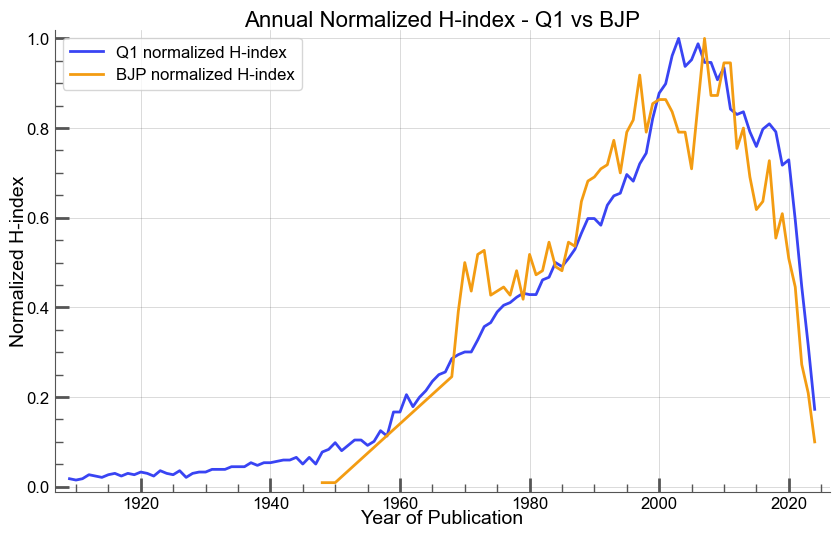

In [10]:
def h_index_array(citations):
    if len(citations) == 0:
        return 0
    citations_sorted = np.sort(citations)[::-1]
    h = np.arange(1, len(citations_sorted)+1)
    return int(np.max(np.minimum(citations_sorted, h)))

def h_index_yearly(df):
    years = sorted(df["year"].unique().to_list())
    h_vals = []

    for y in years:
        citations = np.array(df.filter(pl.col("year") == y)["cited_by_count"].to_list())
        h_vals.append(h_index_array(citations))

    h_vals = np.array(h_vals)
    h_max = h_vals.max() if len(h_vals) > 0 else 1
    h_norm = h_vals / h_max
    return years, h_norm

years_q1, h_q1 = h_index_yearly(works)
years_bjp, h_bjp = h_index_yearly(works_bjp)

with aq.load_theme("scientific"):
    plt.figure(figsize=(10,6))
    plt.plot(years_q1, h_q1, color="#3944f3", label="Q1 normalized H-index", linewidth=2)
    plt.plot(years_bjp, h_bjp, color="#f39c12", label="BJP normalized H-index", linewidth=2)
    plt.xlabel("Year of Publication", fontsize=14)
    plt.ylabel("Normalized H-index", fontsize=14)
    plt.title("Annual Normalized H-index - Q1 vs BJP", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

(5, 108) (5, 57)


<Figure size 640x480 with 0 Axes>

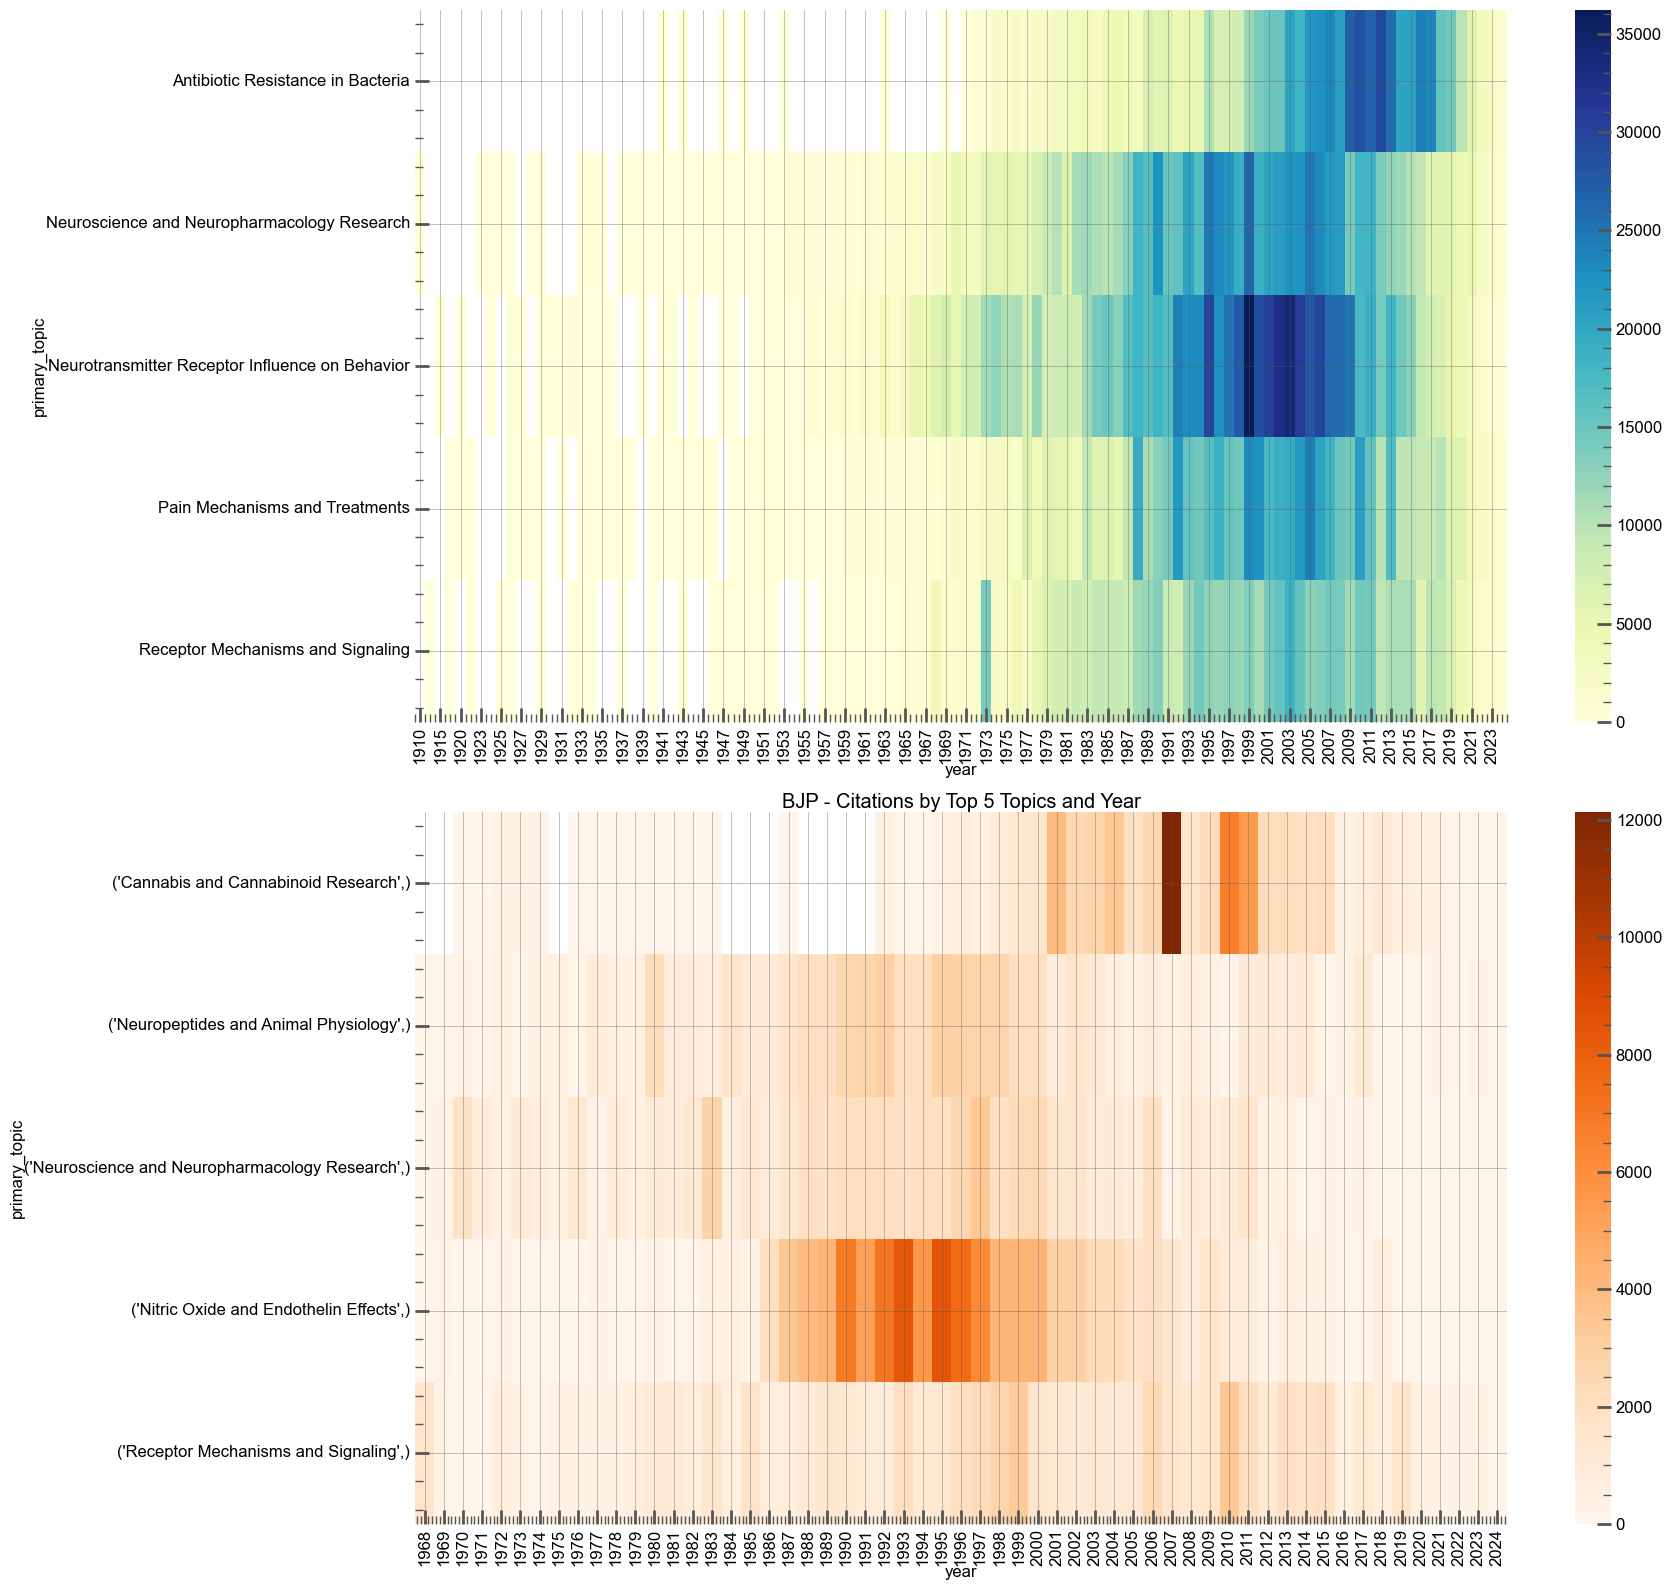

In [11]:


top5_topics_works = (
    works.group_by("primary_topic")
         .agg(pl.sum("cited_by_count").alias("total_citations"))
         .sort("total_citations", descending=True)
         .head(5)   
         .select("primary_topic")
         .to_series()
         .to_list()
)

top5_topics_works_bjp = (
    works_bjp.group_by("primary_topic")
         .agg(pl.sum("cited_by_count").alias("total_citations"))
         .sort("total_citations", descending=True)
         .head(5)  
         .select("primary_topic")
         .to_series()
         .to_list()
)

existing_topics_works = works.select("primary_topic").unique().to_series().to_list()
valid_top5 = [t for t in top5_topics_works if t in existing_topics_works]

heatmap_works = (
    works.filter(pl.col("primary_topic").is_in(valid_top5))
         .group_by(["year", "primary_topic"])
         .agg(pl.sum("cited_by_count").alias("cited_by_count"))
)

existing_topics_bjp = works_bjp.select("primary_topic").unique().to_series().to_list()
valid_top5_bjp = [t for t in top5_topics_works_bjp if t in existing_topics_bjp]

heatmap_bjp = (
    works_bjp.filter(pl.col("primary_topic").is_in(valid_top5_bjp))
             .group_by(["year", "primary_topic"])
             .agg(pl.sum("cited_by_count").alias("cited_by_count"))
)

pivot_works = heatmap_works.to_pandas().pivot_table(
    index='primary_topic', columns='year', values='cited_by_count', aggfunc='sum'
)
pivot_bjp = heatmap_bjp.to_pandas().pivot_table(
    index='primary_topic', columns='year', values='cited_by_count', aggfunc='sum'
)

print(pivot_works.shape, pivot_bjp.shape)

fig, axes = plt.subplots(2, 1, figsize=(18, 16))
sns.heatmap(pivot_works, cmap="YlGnBu", ax=axes[0])
axes[1].set_title("Q1 - Citations by Top 5 Topics and Year")
sns.heatmap(pivot_bjp, cmap="Oranges", ax=axes[1])
axes[1].set_title("BJP - Citations by Top 5 Topics and Year")
plt.tight_layout()
plt.show()


C:\Users\noahr\AppData\Local\Temp\ipykernel_18612\2322812291.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  (pl.col("is_top_10_percent").sum() / pl.count() * 100).alias("pct_top10")


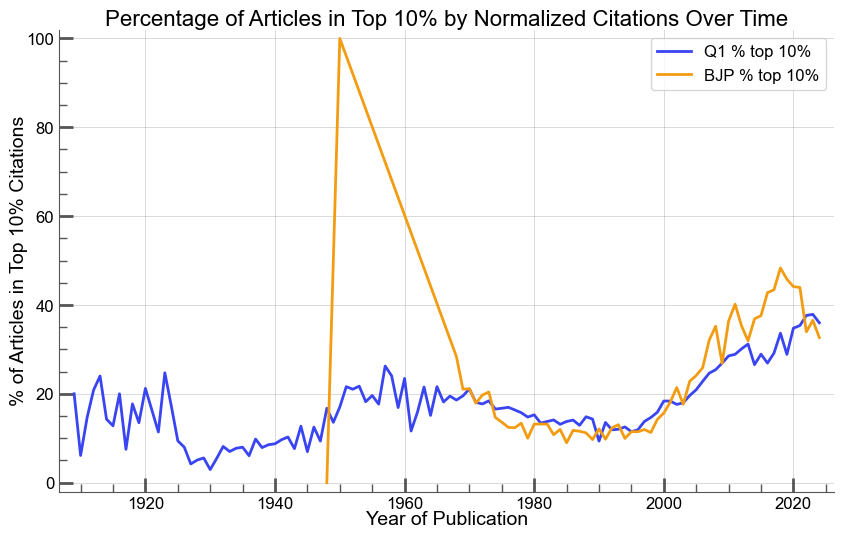

In [ ]:


def top10_percent_per_year(df):
    grouped = (
        df.group_by("year", maintain_order=True)
          .agg([
              (pl.col("is_top_10_percent").sum() / pl.count() * 100).alias("pct_top10")
          ])
          .sort("year")
    )
    return grouped

q1_top10_year = top10_percent_per_year(works)
bjp_top10_year = top10_percent_per_year(works_bjp)

with aq.load_theme("scientific"):
    plt.figure(figsize=(10,6))
    plt.plot(q1_top10_year["year"].to_numpy(), q1_top10_year["pct_top10"].to_numpy(),
             color="#3944f3", label="Q1 % top 10%", linewidth=2)
    plt.plot(bjp_top10_year["year"].to_numpy(), bjp_top10_year["pct_top10"].to_numpy(),
             color="#f39c12", label="BJP % top 10%", linewidth=2)
    plt.xlabel("Year of Publication", fontsize=14)
    plt.ylabel("% of Articles in Top 10% Citations", fontsize=14)
    plt.title("Percentage of Articles in Top 10% by Normalized Citations Over Time", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

shape: (116, 2)
┌──────┬───────────┐
│ year ┆ pct_top1  │
│ ---  ┆ ---       │
│ i64  ┆ f64       │
╞══════╪═══════════╡
│ 1909 ┆ 3.333333  │
│ 1910 ┆ 2.040816  │
│ 1911 ┆ 0.0       │
│ 1912 ┆ 0.0       │
│ 1913 ┆ 2.0       │
│ …    ┆ …         │
│ 2020 ┆ 33.113875 │
│ 2021 ┆ 34.276084 │
│ 2022 ┆ 37.015336 │
│ 2023 ┆ 37.260616 │
│ 2024 ┆ 35.747839 │
└──────┴───────────┘


<Figure size 640x480 with 0 Axes>

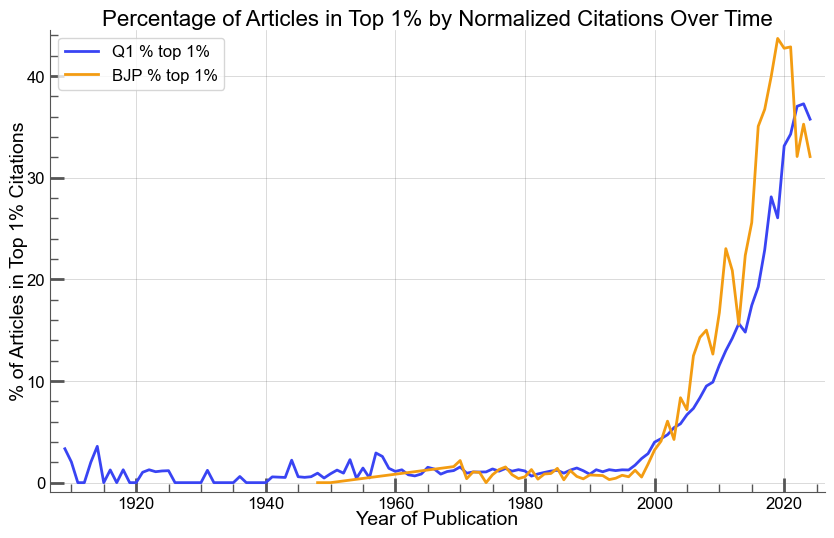

In [ ]:
def top1_percent_per_year(df):
    grouped = (
        df.group_by("year", maintain_order=True)
          .agg([
              (pl.col("is_top_1_percent").sum() / pl.len() * 100).alias("pct_top1")
          ])
          .sort("year")
    )
    return grouped

q1_top1_year = top1_percent_per_year(works)
bjp_top1_year = top1_percent_per_year(works_bjp)
print(q1_top1_year)

with aq.load_theme("scientific"):
    plt.figure(figsize=(10,6))
    plt.plot(q1_top1_year["year"].to_numpy(), q1_top1_year["pct_top1"].to_numpy(),
             color="#3944f3", label="Q1 % top 1%", linewidth=2)
    plt.plot(bjp_top1_year["year"].to_numpy(), bjp_top1_year["pct_top1"].to_numpy(),
             color="#f39c12", label="BJP % top 1%", linewidth=2)
    plt.xlabel("Year of Publication", fontsize=14)
    plt.ylabel("% of Articles in Top 1% Citations", fontsize=14)
    plt.title("Percentage of Articles in Top 1% by Normalized Citations Over Time", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

In [ ]:

total_q1 = works.height
top1_q1 = works.filter(pl.col("is_top_1_percent") == True).height
top10_q1 = works.filter(pl.col("is_top_10_percent") == True).height

pct_top1_q1 = top1_q1 / total_q1 * 100
pct_top10_q1 = top10_q1 / total_q1 * 100

print(f"Q1: {pct_top1_q1:.2f}% of articles in top 1%")
print(f"Q1: {pct_top10_q1:.2f}% of articles in top 10%")

total_bjp = works_bjp.height
top1_bjp = works_bjp.filter(pl.col("is_top_1_percent") == True).height
top10_bjp = works_bjp.filter(pl.col("is_top_10_percent") == True).height

pct_top1_bjp = top1_bjp / total_bjp * 100
pct_top10_bjp = top10_bjp / total_bjp * 100

print(f"BJP: {pct_top1_bjp:.2f}% of articles in top 1%")
print(f"BJP: {pct_top10_bjp:.2f}% of articles in top 10%")


Q1: 14.16% of articles in top 1%
Q1: 24.33% of articles in top 10%
BJP: 9.80% of articles in top 1%
BJP: 21.79% of articles in top 10%


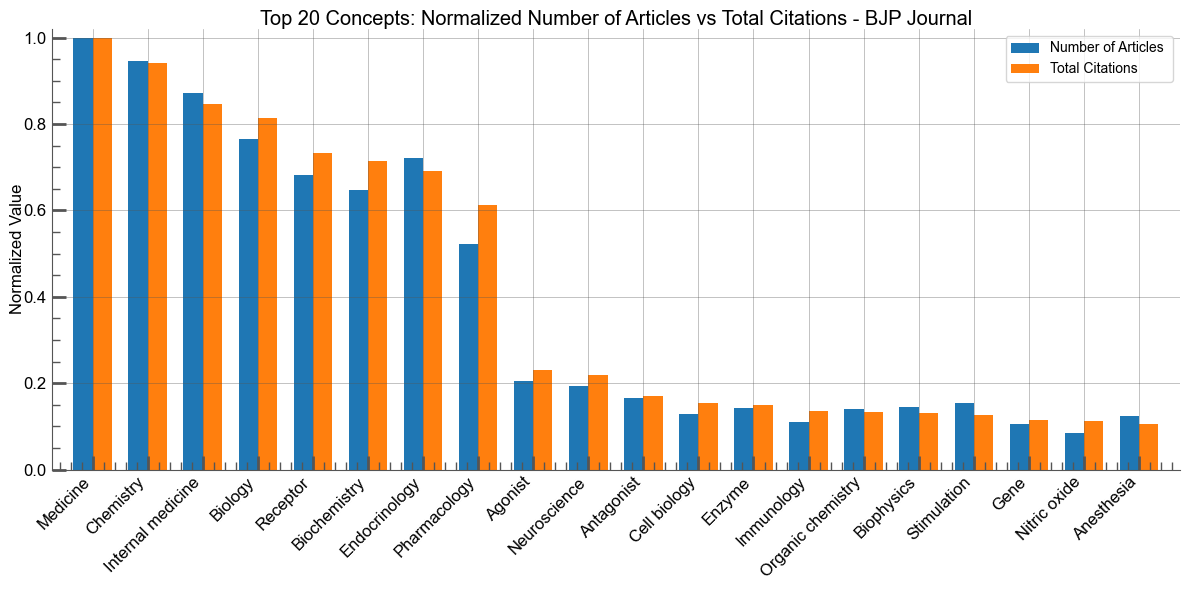

In [40]:
import ast
from itertools import chain

def prepare_concepts_top20_norm(df):
    parsed = [
        [c["display_name"] for c in ast.literal_eval(x)] if x not in [None, ""] else []
        for x in df["concepts"].to_list()
    ]

    concepts = pl.Series("concept", list(chain.from_iterable(parsed)))
    citations = pl.Series(
        "cited_by_count",
        list(chain.from_iterable(
            [[c] * len(p) for c, p in zip(df["cited_by_count"].to_list(), parsed)]
        ))
    )

    exploded = pl.DataFrame({"concept": concepts, "cited_by_count": citations})

    df_top20 = (
        exploded
        .group_by("concept")
        .agg([
            pl.len().alias("n_articles"),
            pl.sum("cited_by_count").alias("total_citations")
        ])
        .sort("total_citations", descending=True)
        .head(20)
        .to_pandas()
    )

    # Normalisation 0-1
    df_top20["n_articles_norm"] = df_top20["n_articles"] / df_top20["n_articles"].max()
    df_top20["total_citations_norm"] = df_top20["total_citations"] / df_top20["total_citations"].max()

    return df_top20

top_concepts_bjp = prepare_concepts_top20_norm(works_bjp)

x = np.arange(len(top_concepts_bjp))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, top_concepts_bjp["n_articles_norm"], width, label="Number of Articles ", color="tab:blue")
plt.bar(x + width/2, top_concepts_bjp["total_citations_norm"], width, label="Total Citations ", color="tab:orange")
plt.xticks(x, top_concepts_bjp["concept"], rotation=45, ha="right")
plt.ylabel("Normalized Value")
plt.title("Top 20 Concepts: Normalized Number of Articles vs Total Citations - BJP Journal")
plt.legend()
plt.tight_layout()
plt.show()


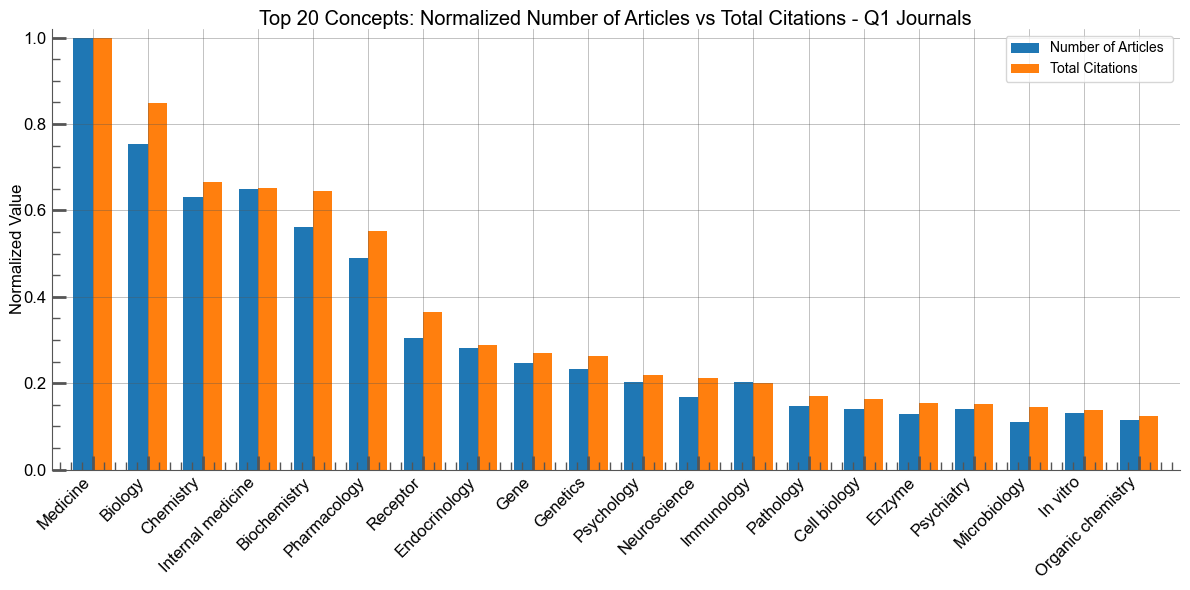

In [41]:
top_concepts_q1 = prepare_concepts_top20_norm(works)

x = np.arange(len(top_concepts_q1))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, top_concepts_q1["n_articles_norm"], width, label="Number of Articles ", color="tab:blue")
plt.bar(x + width/2, top_concepts_q1["total_citations_norm"], width, label="Total Citations ", color="tab:orange")
plt.xticks(x, top_concepts_q1["concept"], rotation=45, ha="right")
plt.ylabel("Normalized Value")
plt.title("Top 20 Concepts: Normalized Number of Articles vs Total Citations - Q1 Journals")
plt.legend()
plt.tight_layout()
plt.show()


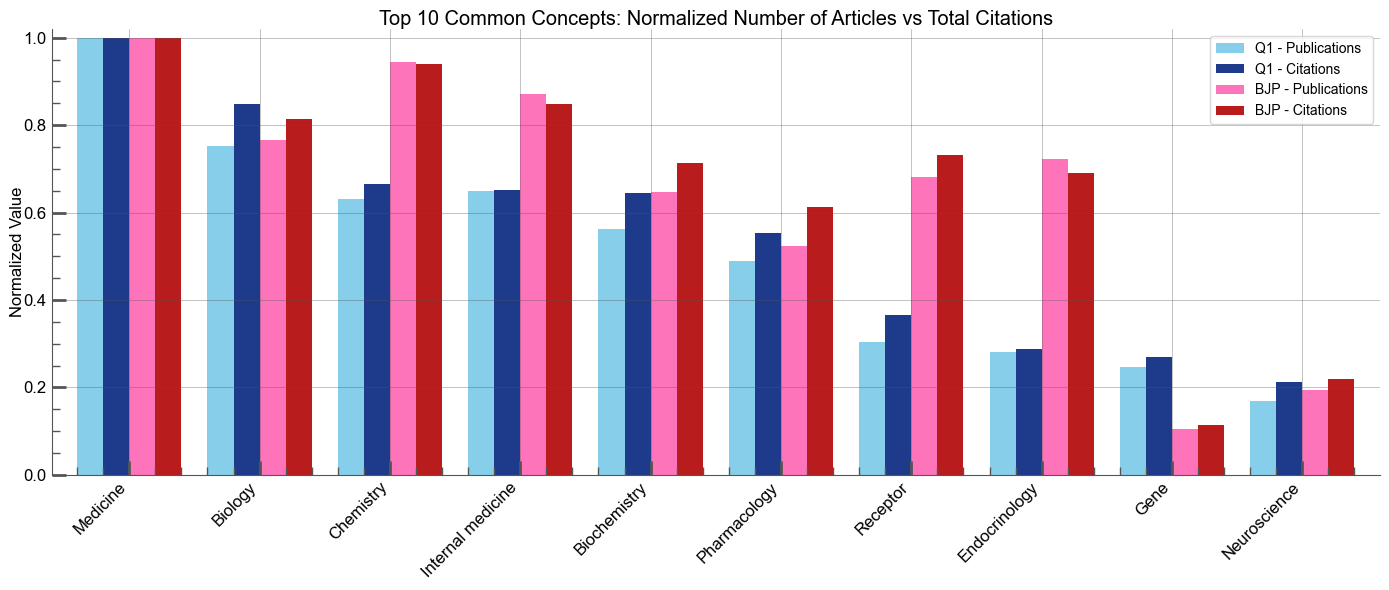

In [43]:
common_concepts = set(top_concepts_bjp["concept"]) & set(top_concepts_q1["concept"])

df_common = pd.merge(
    top_concepts_bjp, 
    top_concepts_q1, 
    on="concept", 
    suffixes=("_bjp", "_q1")
)
df_common = df_common[df_common["concept"].isin(common_concepts)]
df_common["total_citations_sum"] = df_common["total_citations_bjp"] + df_common["total_citations_q1"]
df_common = df_common.sort_values("total_citations_sum", ascending=False).head(10)

x = np.arange(len(df_common))
width = 0.2

plt.figure(figsize=(14,6))

plt.bar(x - 1.5*width, df_common["n_articles_norm_q1"], width, label="Q1 - Publications", color="#87CEEB")
plt.bar(x - 0.5*width, df_common["total_citations_norm_q1"], width, label="Q1 - Citations", color="#1E3A8A")
plt.bar(x + 0.5*width, df_common["n_articles_norm_bjp"], width, label="BJP - Publications", color="#FD74BB")
plt.bar(x + 1.5*width, df_common["total_citations_norm_bjp"], width, label="BJP - Citations", color="#B91C1C")

plt.xticks(x, df_common["concept"], rotation=45, ha="right")
plt.ylabel("Normalized Value")
plt.title("Top 10 Common Concepts: Normalized Number of Articles vs Total Citations")
plt.legend()
plt.tight_layout()
plt.show()
